In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
from matplotlib import pyplot as plt
from bin.evaluation import plot_roc_curve, plot_oasis_curves, plot_precision_recall_curve
from bin.utils import parse_netMHCIIpan_table, series2records, iterate_fasta
from matplotlib import ticker
from sklearn import metrics
from sklearn.linear_model import LinearRegression

%config InlineBackend.figure_format = 'retina'
pd.set_option('max_colwidth', 200)

In [2]:
TASK_DIR = '../../data/tasks/immunogenicity'
PERCENTILE_TABLE_PATH = '../../data/tasks/humanness/imgt_mab_db_percentile.tsv'
PREFIX = os.path.join(TASK_DIR, 'mabs')

In [3]:
COLORS = {
    'Human': 'tab:blue',
    'Humanized': 'tab:green',
    'Chimeric': 'tab:orange',
    'Mouse': 'tab:red',
    'Humanized/Chimeric': 'tab:purple',
}

In [4]:
mabs = pd.read_csv(os.path.join(TASK_DIR, 'immunogenicity.tsv'), sep='\t').set_index('Name', verify_integrity=True)
mabs.head(5)

,Immunogenicity,Species,Reference
Name,,,
3F8,100.0,Mouse,https://www.nature.com/articles/s41598-018-32986-y#ref-CR1
moAb_81C6,100.0,Mouse,https://www.nature.com/articles/s41598-018-32986-y#ref-CR1
Arcitumomab,0.5,Mouse,https://www.nature.com/articles/s41598-018-32986-y#ref-CR1
Blinatumomab,1.4,Mouse,https://www.nature.com/articles/s41598-018-32986-y#ref-CR1
Ibritumomab,1.9,Mouse,https://www.nature.com/articles/s41598-018-32986-y#ref-CR1


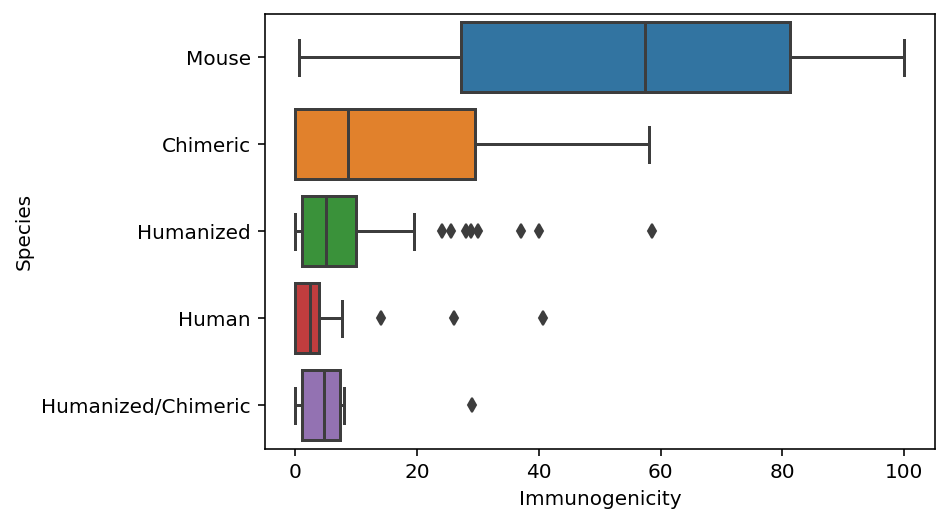

In [5]:
sns.boxplot(
    data=mabs,
    y='Species',
    x='Immunogenicity'
);

In [6]:
def seq_id_to_antibody(seq_id):
    return seq_id.split()[0]

# Humanness scores

## Hu-mAb

In [7]:
humab = pd.read_csv(PREFIX+'_humab.tsv', sep='\t', index_col=0)['Hu-mAb']
humab = humab.groupby(humab.index.map(seq_id_to_antibody)).mean()
humab = humab.loc[mabs.index]
humab.head()

Name
3F8             0.0100
moAb_81C6       0.0000
Arcitumomab     0.0000
Blinatumomab    0.0560
Ibritumomab     0.0005
Name: Hu-mAb, dtype: float64

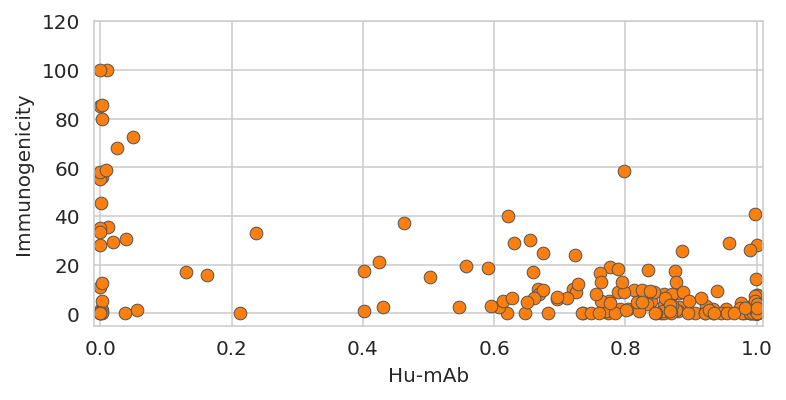

In [8]:
with sns.axes_style('whitegrid'):
    fig, ax = plt.subplots(figsize=(6, 2.8))
    sns.scatterplot(
        x=humab,
        y=mabs['Immunogenicity'],
        s=40,
        edgecolor='#555',
        color='tab:orange'
    )
    ax.set_ylim(-5, 120);
    ax.set_xlim(-0.01, 1.01)

In [9]:
pd.read_csv(PREFIX+'_humab.tsv', sep='\t', index_col=0)['Hu-mAb'].head()

Antibody
3F8 VH            0.00
3F8 VL            0.02
moAb_81C6 VH      0.00
moAb_81C6 VL      0.00
Pexelizumab VH    0.99
Name: Hu-mAb, dtype: float64

In [10]:
humab.head()

Name
3F8             0.0100
moAb_81C6       0.0000
Arcitumomab     0.0000
Blinatumomab    0.0560
Ibritumomab     0.0005
Name: Hu-mAb, dtype: float64

## OASis

In [11]:
oasis_curves = pd.read_excel(PREFIX+'_oasis.xlsx', sheet_name='OASis Curves', index_col=0)
oasis_curves = oasis_curves.loc[mabs.index]
oasis_curves.head()

,0%,1%,2%,3%,4%,5%,6%,7%,8%,9%,...,81%,82%,83%,84%,85%,86%,87%,88%,89%,90%
Name,,,,,,,,,,,,,,,,,,,,,
3F8,1.0,0.681159,0.632850,0.613527,0.589372,0.570048,0.550725,0.550725,0.531401,0.502415,...,0.202899,0.198068,0.198068,0.198068,0.193237,0.193237,0.193237,0.193237,0.188406,0.188406
moAb_81C6,1.0,0.629108,0.610329,0.610329,0.605634,0.596244,0.563380,0.544601,0.535211,0.516432,...,0.361502,0.361502,0.361502,0.361502,0.361502,0.361502,0.361502,0.361502,0.352113,0.352113
Arcitumomab,1.0,0.767773,0.720379,0.682464,0.635071,0.616114,0.616114,0.616114,0.611374,0.606635,...,0.308057,0.308057,0.308057,0.308057,0.303318,0.303318,0.303318,0.298578,0.293839,0.284360
Blinatumomab,1.0,0.607306,0.593607,0.575342,0.552511,0.529680,0.515982,0.511416,0.502283,0.493151,...,0.260274,0.260274,0.255708,0.255708,0.251142,0.242009,0.242009,0.237443,0.237443,0.228311
Ibritumomab,1.0,0.603774,0.575472,0.523585,0.495283,0.481132,0.476415,0.462264,0.452830,0.429245,...,0.117925,0.117925,0.117925,0.117925,0.117925,0.117925,0.113208,0.108491,0.108491,0.108491


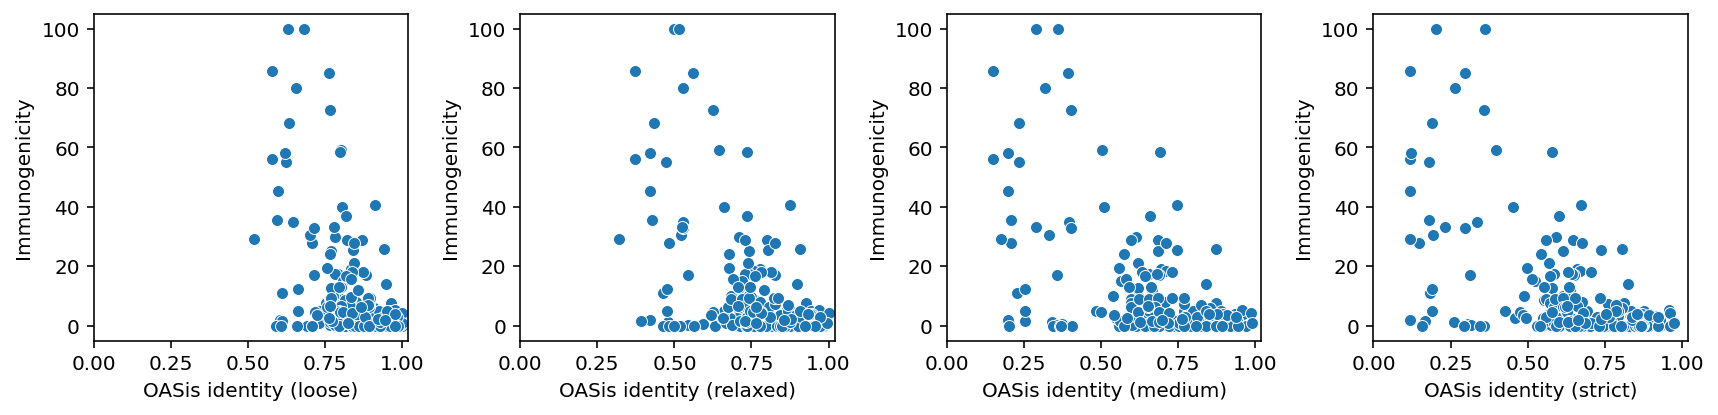

In [12]:
oasis_loose = oasis_curves['1%'].rename('OASis identity (loose)')
oasis_relaxed = oasis_curves['10%'].rename('OASis identity (relaxed)')
oasis_medium = oasis_curves['50%'].rename('OASis identity (medium)')
oasis_strict = oasis_curves['80%'].rename('OASis identity (strict)')

fig, axes = plt.subplots(1, 4, figsize=(12, 3))
sns.scatterplot(x=oasis_loose, y=mabs['Immunogenicity'], ax=axes[0])
sns.scatterplot(x=oasis_relaxed, y=mabs['Immunogenicity'], ax=axes[1])
sns.scatterplot(x=oasis_medium, y=mabs['Immunogenicity'], ax=axes[2])
sns.scatterplot(x=oasis_strict, y=mabs['Immunogenicity'], ax=axes[3])
for ax in axes:
    ax.set_xlim(0, 1.02);
fig.tight_layout();

## OASis Percentile

In [13]:
PERCENTILES = pd.read_table(PERCENTILE_TABLE_PATH, index_col=0)
PERCENTILES.head()

,1%,2%,3%,4%,5%,6%,7%,8%,9%,10%,...,81%,82%,83%,84%,85%,86%,87%,88%,89%,90%
humanness,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
def get_oasis_percentile(oasis_identity: float, min_fraction_subjects: float):
    if np.isnan(oasis_identity):
        return np.nan
    subjects_key = f'{int(min_fraction_subjects*100)}%'
    identity_lower_bound = int(np.floor(oasis_identity*100))
    identity_upper_bound = int(np.ceil(oasis_identity*100-0.00000001))
    correction = oasis_identity*100 - np.floor(oasis_identity*100)
    lower = PERCENTILES[subjects_key][identity_lower_bound]
    upper = PERCENTILES[subjects_key][identity_upper_bound]
    return lower + (upper - lower) * correction

In [15]:
oasis_loose_percentile = oasis_loose.apply(lambda i: get_oasis_percentile(i, 0.01)).rename('OASis percentile (loose)')
oasis_relaxed_percentile = oasis_relaxed.apply(lambda i: get_oasis_percentile(i, 0.1)).rename('OASis percentile (relaxed)')
oasis_medium_percentile = oasis_medium.apply(lambda i: get_oasis_percentile(i, 0.5)).rename('OASis percentile (medium)')
oasis_strict_percentile = oasis_strict.apply(lambda i: get_oasis_percentile(i, 0.9)).rename('OASis percentile (strict)')
oasis_strict_percentile.head()

Name
3F8             0.037748
moAb_81C6       0.101863
Arcitumomab     0.085501
Blinatumomab    0.064024
Ibritumomab     0.006356
Name: OASis percentile (strict), dtype: float64

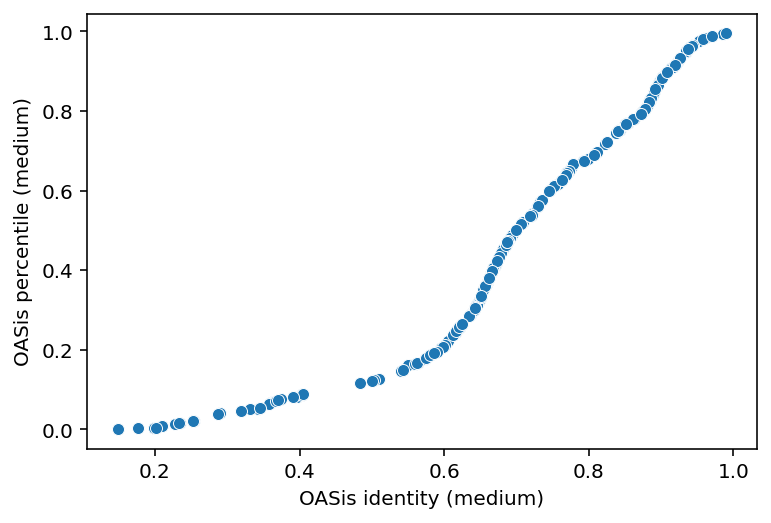

In [16]:
sns.scatterplot(x=oasis_medium, y=oasis_medium_percentile);

0-20%           AxesSubplot(0.1,0.15;0.0677966x0.75)
20-40%     AxesSubplot(0.181356,0.15;0.0677966x0.75)
40-60%     AxesSubplot(0.262712,0.15;0.0677966x0.75)
60-80%     AxesSubplot(0.344068,0.15;0.0677966x0.75)
80-100%    AxesSubplot(0.425424,0.15;0.0677966x0.75)
dtype: object

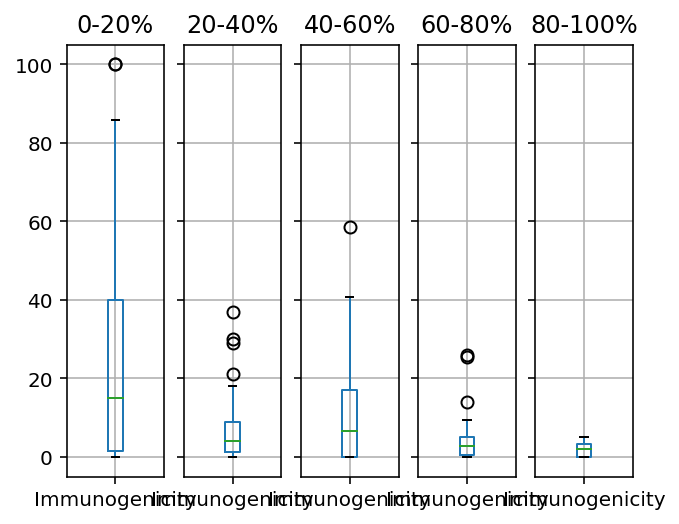

In [17]:
percentile_bins = ((oasis_medium_percentile * 5).astype(int) * 20).apply(lambda v: f'{v}-{v+20}%')
mabs.groupby(percentile_bins).boxplot(layout=(1, 10), figsize=(10, 4))

## OASis + NetMHCIIpan

In [18]:
netmhc = parse_netMHCIIpan_table('../../data/tasks/immunogenicity/mabs_netMHCIIpan.tsv', rank_strong=2, rank_weak=10)
netmhc = netmhc.reset_index()[['Peptide','SB_Alleles','WB+SB_Alleles']].drop_duplicates().set_index('Peptide')
assert netmhc.index.is_unique
netmhc.head()

,SB_Alleles,WB+SB_Alleles
Peptide,,
QVQLKESGP,0,0
VQLKESGPG,0,0
QLKESGPGL,0,0
LKESGPGLV,0,0
KESGPGLVA,0,0


In [19]:
netmhc['SB_Alleles'].value_counts()

0    19713
1      394
2      186
3       92
4       61
5       40
6       35
7       20
8       11
Name: SB_Alleles, dtype: int64

In [20]:
netmhc['WB+SB_Alleles'].value_counts()

0    17221
1     1200
2      583
3      420
4      293
8      237
6      223
5      207
7      168
Name: WB+SB_Alleles, dtype: int64

In [21]:
oasis_sheets = pd.read_excel(PREFIX+'_oasis.xlsx', sheet_name=None)
oasis_peptides = pd.concat([oasis_sheets[name] for name in mabs.index])[['Antibody', 'Peptide Seq', 'Peptide Fraction OAS Subjects']]
del oasis_sheets
oasis_peptides = oasis_peptides[~oasis_peptides['Peptide Seq'].isna()]
oasis_peptides = oasis_peptides.merge(netmhc[['SB_Alleles','WB+SB_Alleles']], left_on='Peptide Seq', right_index=True, how='outer')
assert oasis_peptides.isna().sum().sum() == 0
oasis_peptides.head()

,Antibody,Peptide Seq,Peptide Fraction OAS Subjects,SB_Alleles,WB+SB_Alleles
4,3F8,QVQLKESGP,0.906667,0,0
4,Derlotuximab,QVQLKESGP,0.906667,0,0
5,3F8,VQLKESGPG,0.902222,0,0
5,Derlotuximab,VQLKESGPG,0.902222,0,0
6,3F8,QLKESGPGL,0.920000,0,0


In [22]:
oasis_strong_binders = oasis_peptides[oasis_peptides['SB_Alleles'] >= 1]
len(oasis_strong_binders)

1682

In [23]:
oasis_weak_binders = oasis_peptides[oasis_peptides['WB+SB_Alleles'] >= 1]
len(oasis_weak_binders)

6367

In [24]:
oasis_mhc_all = oasis_weak_binders.groupby('Antibody').size().rename('MHCII binders\n(predicted NetMHCIIpan 3.1)').loc[mabs.index]
oasis_mhc_all

Name
3F8             34
moAb_81C6       35
Arcitumomab     29
Blinatumomab    27
Ibritumomab     32
                ..
Mepolizumab     31
Actoxumab       26
Tosatoxumab     20
Derlotuximab    31
Edrecolomab     25
Name: MHCII binders\n(predicted NetMHCIIpan 3.1), Length: 217, dtype: int64

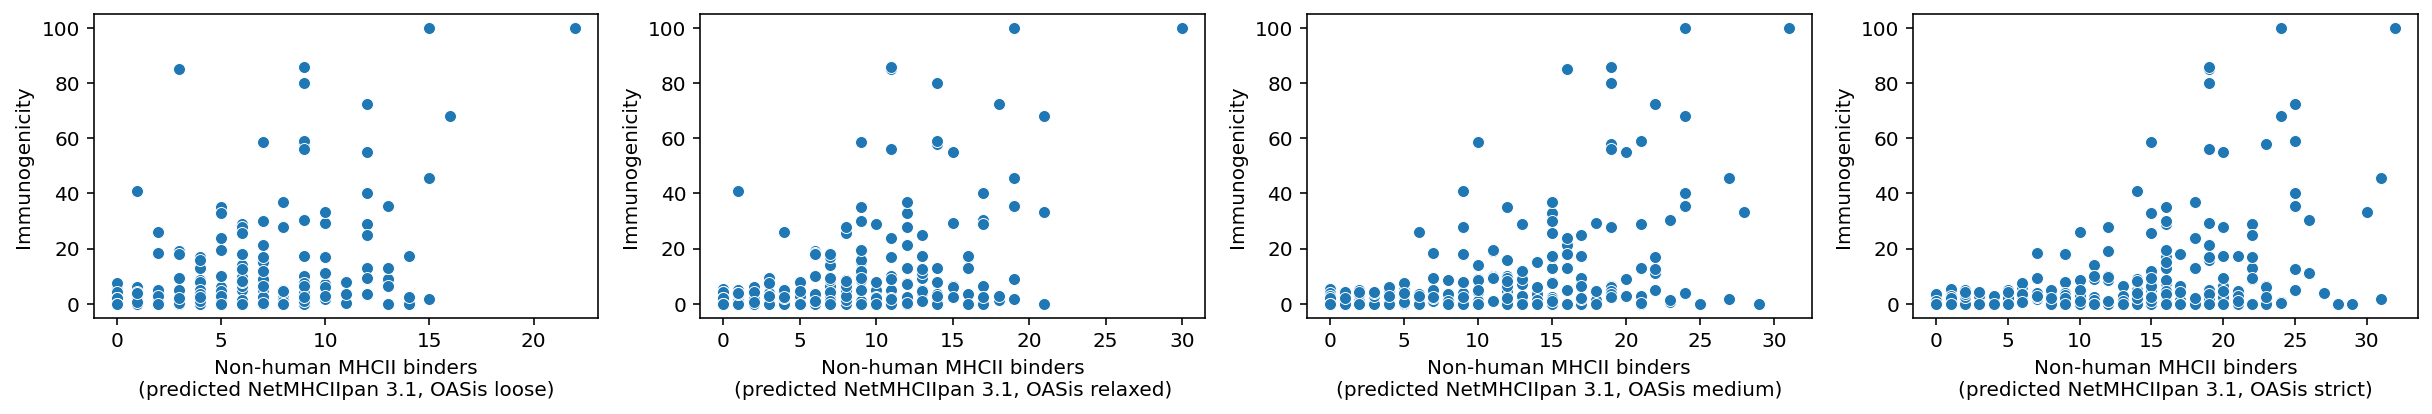

In [25]:
grouped = oasis_weak_binders.groupby('Antibody')['Peptide Fraction OAS Subjects']
oasis_mhc_loose = grouped.apply(lambda s: (s < 0.01).sum()).rename('Non-human MHCII binders\n(predicted NetMHCIIpan 3.1, OASis loose)')
oasis_mhc_relaxed = grouped.apply(lambda s: (s < 0.10).sum()).rename('Non-human MHCII binders\n(predicted NetMHCIIpan 3.1, OASis relaxed)')
oasis_mhc_medium = grouped.apply(lambda s: (s < 0.50).sum()).rename('Non-human MHCII binders\n(predicted NetMHCIIpan 3.1, OASis medium)')
oasis_mhc_strict = grouped.apply(lambda s: (s < 0.90).sum()).rename('Non-human MHCII binders\n(predicted NetMHCIIpan 3.1, OASis strict)')

fig, axes = plt.subplots(1, 4, figsize=(17, 3))
sns.scatterplot(x=oasis_mhc_loose, y=mabs['Immunogenicity'], ax=axes[0])
sns.scatterplot(x=oasis_mhc_relaxed, y=mabs['Immunogenicity'], ax=axes[1])
sns.scatterplot(x=oasis_mhc_medium, y=mabs['Immunogenicity'], ax=axes[2])
sns.scatterplot(x=oasis_mhc_strict, y=mabs['Immunogenicity'], ax=axes[3])
#for ax in axes:
#    ax.set_xlim(0, 1.02);
fig.tight_layout();

In [58]:
oasis_non_human_medium = oasis_peptides.groupby('Antibody')['Peptide Fraction OAS Subjects'].apply(lambda s: (s < 0.50).sum()).rename('Non-human peptides\n(OASis medium)')
oasis_non_human_medium = oasis_non_human_medium.loc[mabs.index]
oasis_non_human_medium

Name
3F8             147
moAb_81C6       136
Arcitumomab     132
Blinatumomab    144
Ibritumomab     170
               ... 
Mepolizumab      73
Actoxumab        23
Tosatoxumab      65
Derlotuximab    151
Edrecolomab     141
Name: Non-human peptides\n(OASis medium), Length: 217, dtype: int64

In [26]:
def compute_regressor_r2(x, y):
    if hasattr(x, 'values'):
        x = x.values
    reg = LinearRegression().fit(x.reshape(-1, 1), y)
    y_pred = reg.predict(x.reshape(-1, 1))
    return metrics.r2_score(y, y_pred)

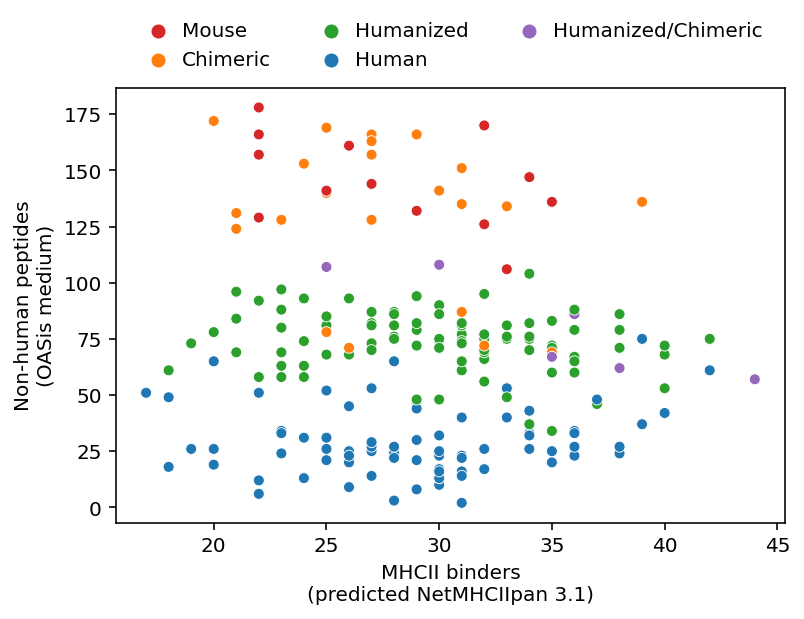

In [59]:
ax = sns.scatterplot(
    x=oasis_mhc_all.loc[mabs.index],
    y=oasis_non_human_medium.loc[mabs.index],
    hue=mabs['Species'],
    palette=COLORS,
    s=30
)
ax.legend(loc='lower center', bbox_to_anchor=(0.5, 1), ncol=3, frameon=False, handletextpad=0.2);

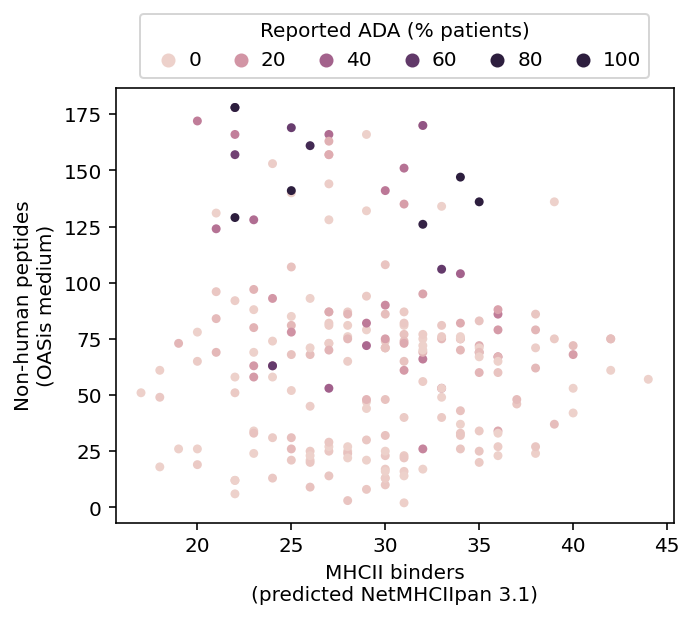

In [60]:
fig, ax = plt.subplots(figsize=(5, 4))
ax = sns.scatterplot(
    x=oasis_mhc_all.loc[mabs.index],
    y=oasis_non_human_medium.loc[mabs.index],
    hue=mabs['Immunogenicity'],
    hue_norm=(0, 75),
    s=20,
    linewidth=0,
    ax=ax
)
ax.legend(loc='lower center', bbox_to_anchor=(0.5, 1), ncol=6, columnspacing=1, handletextpad=0, title='Reported ADA (% patients)')

## MG Score

In [29]:
mg = pd.read_csv(PREFIX+'_MG.tsv', sep='\t').set_index('Name', verify_integrity=True)['Score']
mg = mg.loc[mabs.index]
mg.name = 'MG Score'
mg.head()

Name
3F8             5079.047840
moAb_81C6       5198.380889
Arcitumomab     5382.051287
Blinatumomab    5231.239160
Ibritumomab     4800.138630
Name: MG Score, dtype: float64

## T20 Score

In [30]:
t20 = pd.read_csv(PREFIX+'_T20.tsv', sep='\t', index_col=0)['t20'].rename('T20')
t20 = t20.groupby(t20.index.map(seq_id_to_antibody)).mean()
t20 = t20.loc[mabs.index]
t20.head()

Name
3F8             74.17902
moAb_81C6       75.89372
Arcitumomab     69.73222
Blinatumomab    67.48517
Ibritumomab     65.62782
Name: T20, dtype: float64

## Z-Score

In [31]:
zscore = pd.read_csv(PREFIX+'_Zscore.tsv', sep='\t', index_col=0)['zscore'].rename('Z-score')
zscore = zscore.groupby(zscore.index.map(seq_id_to_antibody)).mean()
zscore = zscore.loc[mabs.index]
zscore.head()

Name
3F8            -1.3485
moAb_81C6      -1.9480
Arcitumomab    -1.0665
Blinatumomab   -1.2355
Ibritumomab    -1.7550
Name: Z-score, dtype: float64

## AbLSTM Score

In [32]:
ablstm = pd.read_csv(PREFIX+'_AbLSTM.tsv', sep='\t', index_col=0)['AbLSTM_score'].rename('AbLSTM')
ablstm = ablstm.groupby(ablstm.index.map(seq_id_to_antibody)).mean()
ablstm = ablstm.reindex(mabs.index)
ablstm.head()

Name
3F8             1.272985
moAb_81C6       1.295034
Arcitumomab     0.813828
Blinatumomab    1.526175
Ibritumomab     1.354340
Name: AbLSTM, dtype: float64

## IgReconstruct Score

In [33]:
igreconstruct = pd.read_csv(PREFIX+'_IgReconstruct.tsv', sep='\t', index_col=0)['Human-Likeness (GenBank)']
igreconstruct = igreconstruct.groupby(igreconstruct.index.map(lambda seq_id: seq_id.rsplit('_', 1)[0])).mean().rename('IgReconstruct')
igreconstruct = igreconstruct.loc[mabs.index]
igreconstruct.head()

Name
3F8            -3.815430
moAb_81C6      -2.487012
Arcitumomab    -2.846324
Blinatumomab   -3.996065
Ibritumomab    -3.314655
Name: IgReconstruct, dtype: float64

## Germline content

In [34]:
germline_content = pd.read_csv(PREFIX+'_GC.tsv', sep='\t', index_col=0)['germline_content']
germline_content = germline_content.groupby(germline_content.index.map(seq_id_to_antibody)).mean().rename('Germline content')
germline_content = germline_content.reindex(mabs.index)
germline_content.head()

Name
3F8             0.634252
moAb_81C6       0.731142
Arcitumomab     0.709184
Blinatumomab    0.685557
Ibritumomab     0.662156
Name: Germline content, dtype: float64

In [35]:
SCORES = [
    (1, t20, '-', '#eecc00', 1.5),
    (1, zscore, '-', 'tab:brown', 1.5),
    (1, igreconstruct, '-', 'tab:cyan', 1.5),
    (-1, ablstm, '-', 'tab:red', 1.5),
    (1, germline_content, '-', 'tab:green', 1.5),
    (1, humab, '-', '#ff9698', 1.5),
    (1, mg, '-', 'black', 1.5),
    (-1, oasis_mhc_loose, ':', 'tab:purple', 1.5),
    (-1, oasis_mhc_relaxed, '-.', 'tab:purple', 1.5),
    (-1, oasis_mhc_medium, '--', 'tab:purple', 1.5),
    (-1, oasis_mhc_strict, '-', 'tab:purple', 1.5),
    (1, oasis_loose, ':', '#a020c0', 1.5),
    (1, oasis_relaxed, '-.', '#a020c0', 1.5),
    (1, oasis_medium, '--', '#a020c0', 1.5),
    (1, oasis_strict, '-', '#a020c0', 1.5),
    (1, oasis_loose_percentile, '--', '#a020c0', 1.5),
    (1, oasis_relaxed_percentile, '--', '#a020c0', 1.5),
    (1, oasis_medium_percentile, '--', '#a020c0', 1.5),
    (1, oasis_strict_percentile, '--', '#a020c0', 1.5),
]
SELECTED_SCORES = [
    (1, t20, '-', '#eecc00', 1.0),
    (1, zscore, '-', 'tab:brown', 1.0),
    (1, igreconstruct, '-', 'tab:cyan', 1.0),
    (-1, ablstm, '-', 'tab:red', 1.0),
    (1, germline_content, '-', 'tab:green', 1.0),
    (1, humab, '-', '#ff9698', 1.0),
    (1, mg, '-', 'black', 1.0),
    (1, oasis_medium.rename('OASis identity'), '-', '#a020c0', 1.5),
    (1, oasis_medium_percentile.rename('OASis percentile'), '-', '#a020c0', 1.5),
]

In [36]:
def plot_correlations(y, scores, hue, colors):
    results = []
    for i, (multiplier, score, ls, color, lw) in enumerate(scores):
        fig, ax = plt.subplots(figsize=(4, 3.5))
        
        corr = score.corr(y)
        corr_label = '  R = {:.2f}  '.format(corr)
        r2 = compute_regressor_r2(score, y)
        r2_label = '  R² = {:.2f}  '.format(r2)
        print(score.name, corr_label, r2_label)
        results.append({'method': score.name, 'R': corr, 'R2': r2})
        for i, (group, group_y) in enumerate(y.groupby(hue)):
            group_corr = score[group_y.index].corr(group_y)
            group_r2 = compute_regressor_r2(score[group_y.index], group_y)
            sns.scatterplot(
                x=score[group_y.index], 
                y=group_y, 
                marker='XoPvs'[i], 
                label=f'{group} (R={group_corr:.2f}, R²={group_r2:.2f})',
                s=30, 
                color=colors[group]
            )
        ax.legend(loc='lower center', handletextpad=0, frameon=False, bbox_to_anchor=(0.5, 1))
                
        if corr < 0:
            ax.text(ax.get_xlim()[1], 101, corr_label, ha='right', va='top', fontsize=11)
            ax.text(ax.get_xlim()[1], 92, r2_label, ha='right', va='top', fontsize=11)
        else:
            ax.text(ax.get_xlim()[0], 101, corr_label, ha='left', va='top', fontsize=11)
            ax.text(ax.get_xlim()[0], 92, r2_label, ha='left', va='top', fontsize=11)
            
        ax.set_xlabel(score.name);
        ax.set_ylabel('Reported ADA (% patients)')
        ax.set_ylim(-5, 105)
        ax.yaxis.labelpad = 0
        ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:.0f}'.format(y))) 
        if score.max() <= 1.01 and score.min() > -0.01:
            ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: '{:.0%}'.format(x))) 
        plt.show();
    return pd.DataFrame(results).set_index('method')

# Immunogenicity classification

T20   R = -0.41     R² = 0.16  


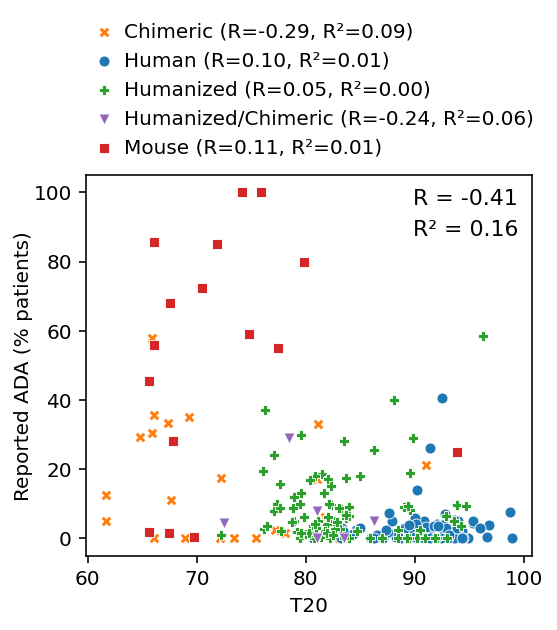

Z-score   R = -0.45     R² = 0.20  


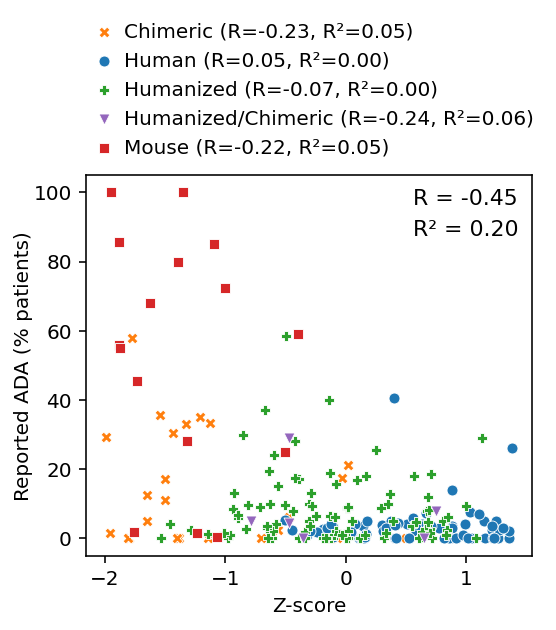

IgReconstruct   R = -0.45     R² = 0.20  


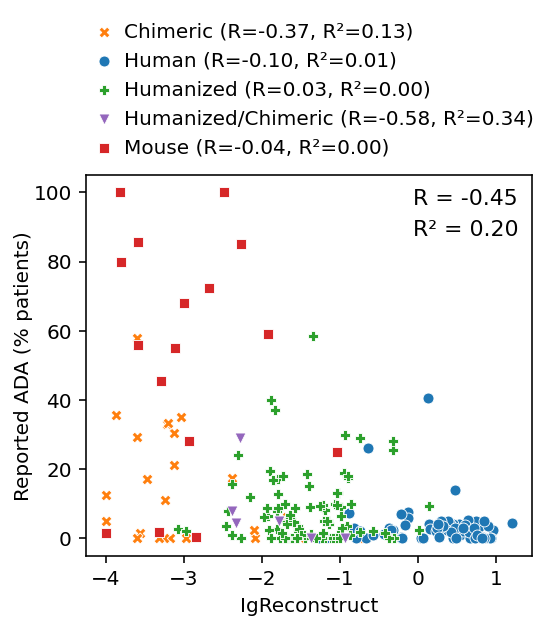

AbLSTM   R = 0.47     R² = 0.22  


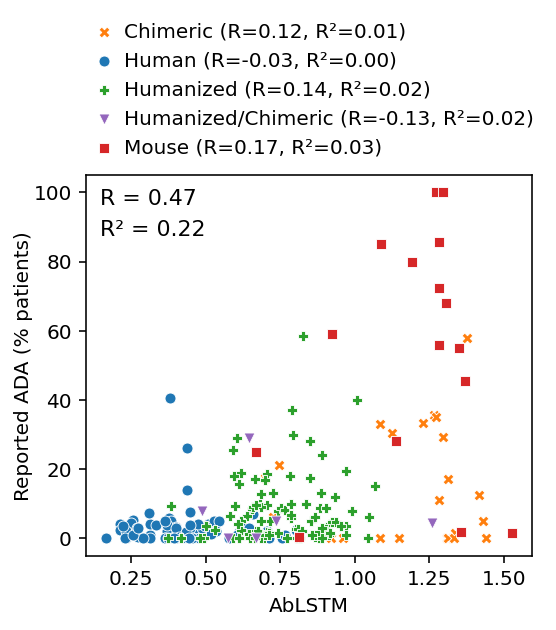

Germline content   R = -0.50     R² = 0.25  


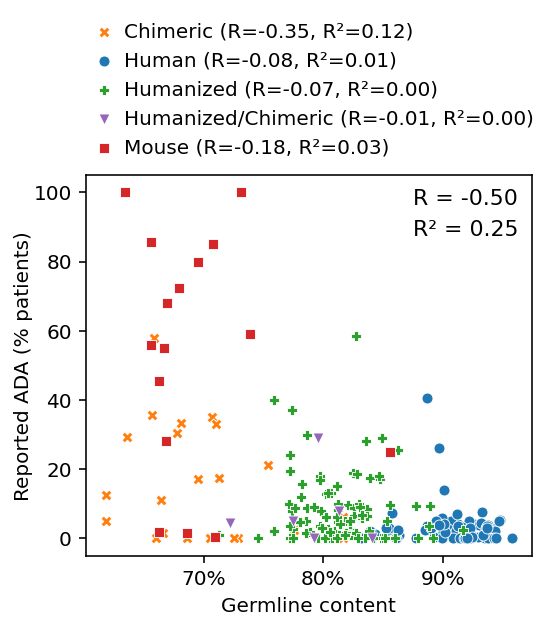

Hu-mAb   R = -0.58     R² = 0.34  


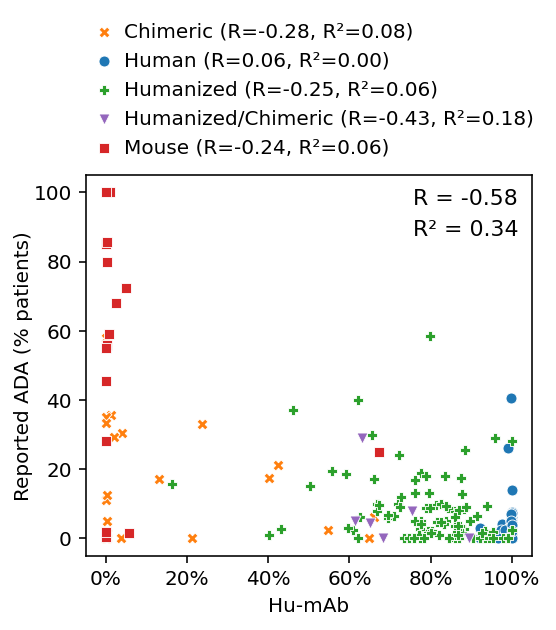

MG Score   R = -0.46     R² = 0.21  


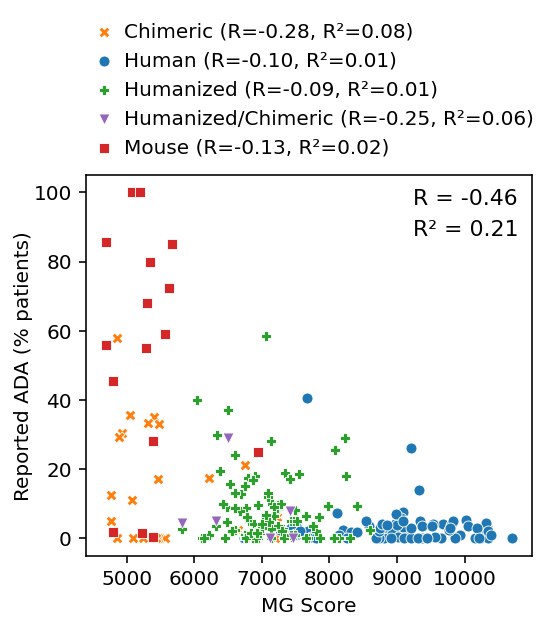

Non-human MHCII binders
(predicted NetMHCIIpan 3.1, OASis loose)   R = 0.45     R² = 0.02  


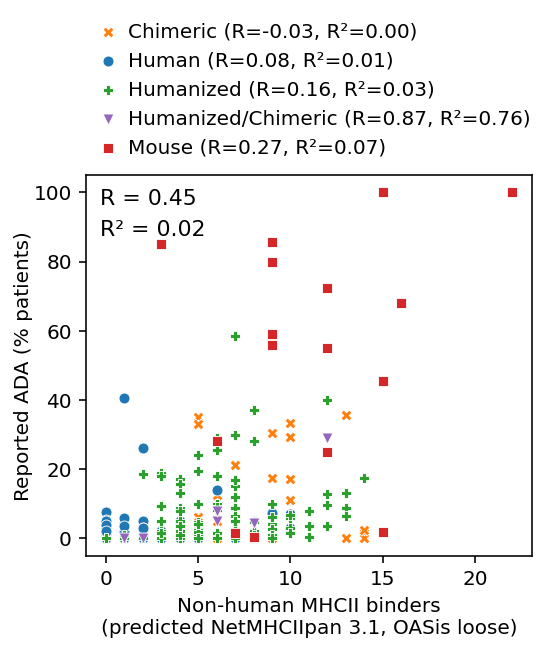

Non-human MHCII binders
(predicted NetMHCIIpan 3.1, OASis relaxed)   R = 0.46     R² = 0.02  


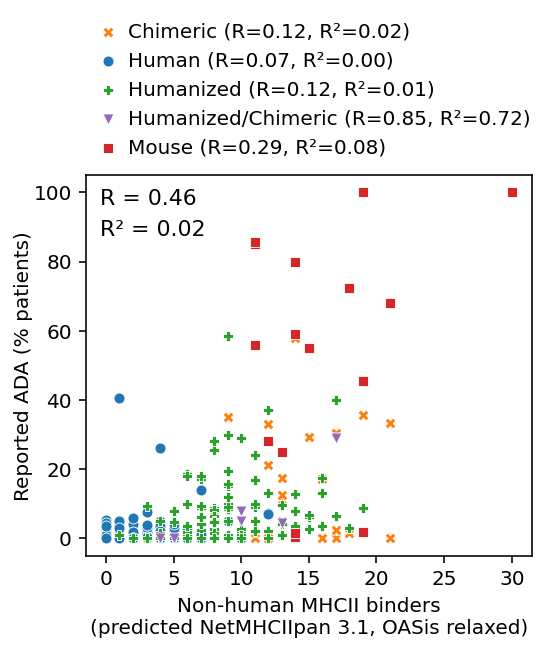

Non-human MHCII binders
(predicted NetMHCIIpan 3.1, OASis medium)   R = 0.44     R² = 0.01  


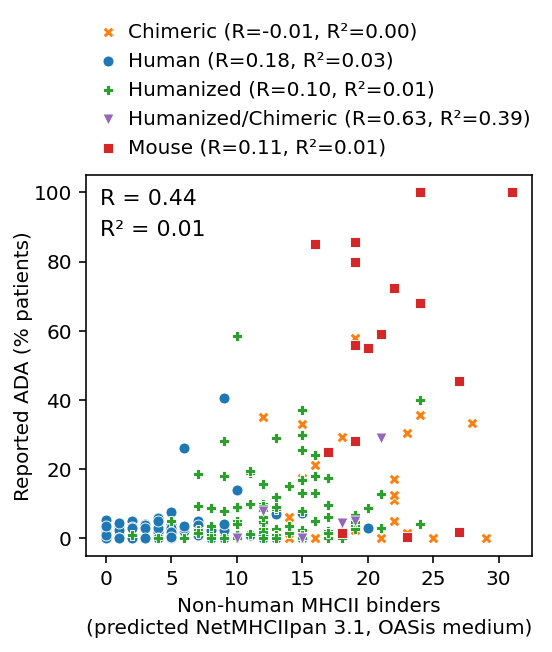

Non-human MHCII binders
(predicted NetMHCIIpan 3.1, OASis strict)   R = 0.41     R² = 0.00  


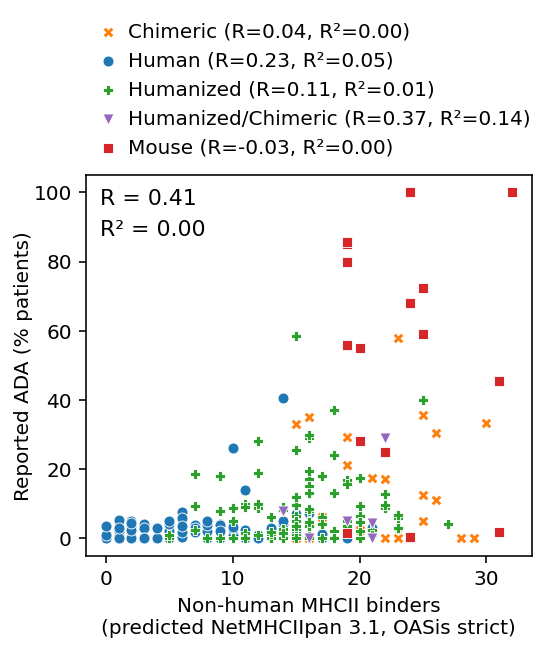

OASis identity (loose)   R = -0.48     R² = 0.23  


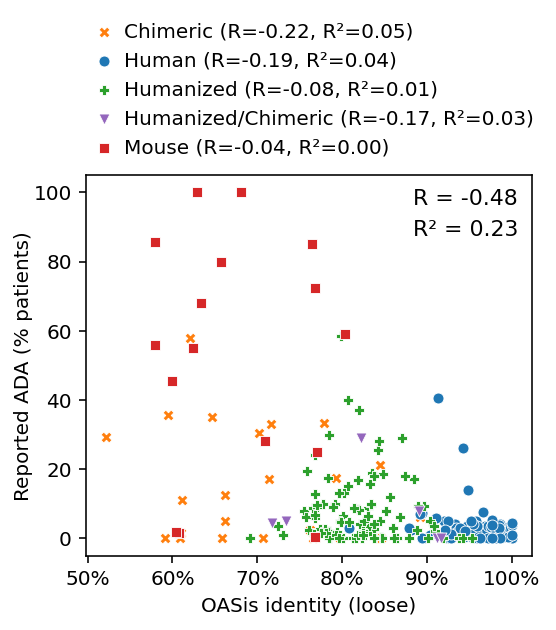

OASis identity (relaxed)   R = -0.51     R² = 0.26  


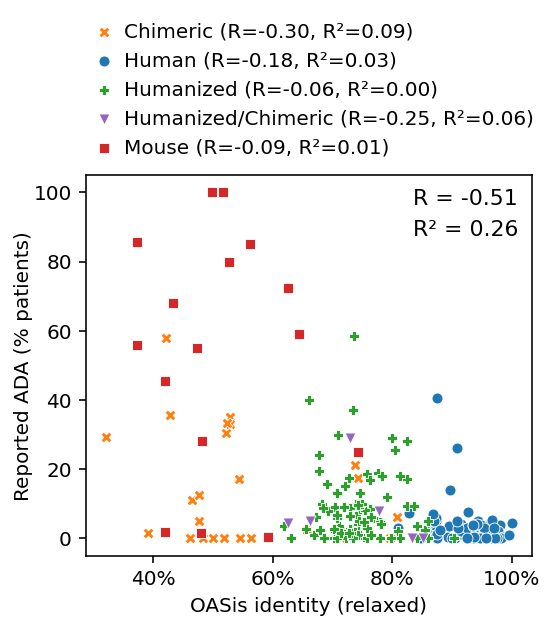

OASis identity (medium)   R = -0.53     R² = 0.28  


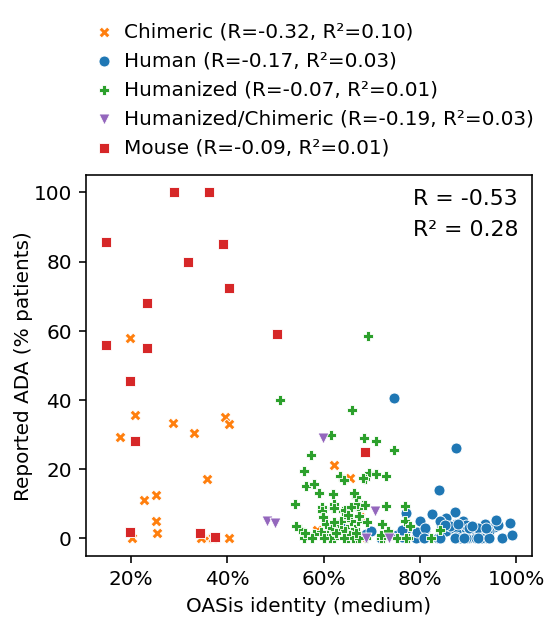

OASis identity (strict)   R = -0.53     R² = 0.28  


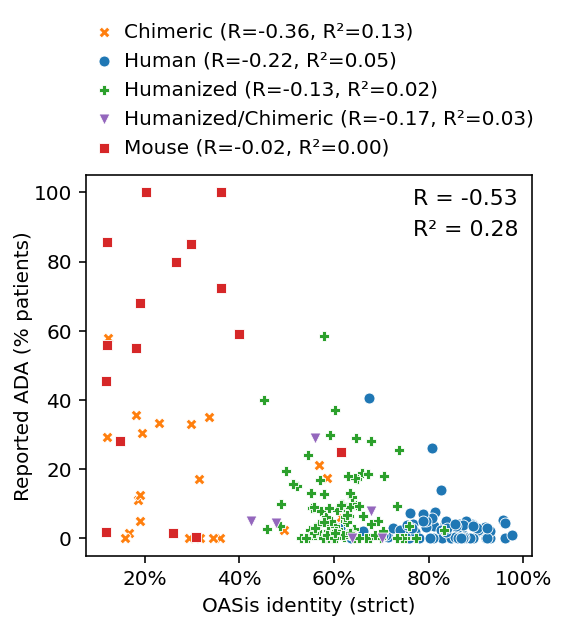

OASis percentile (loose)   R = -0.42     R² = 0.18  


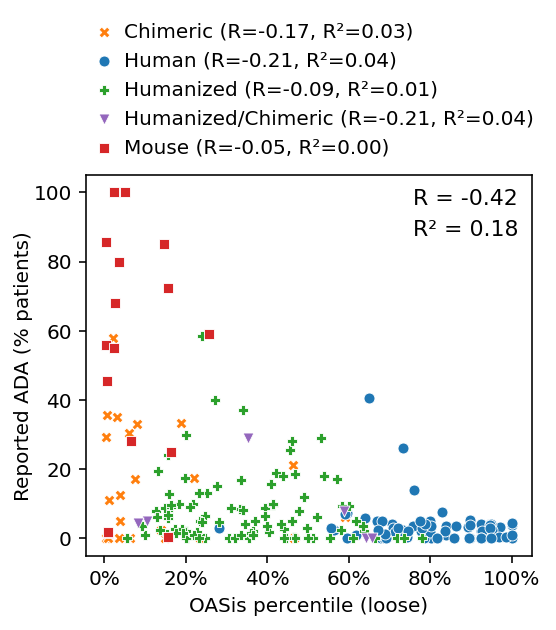

OASis percentile (relaxed)   R = -0.43     R² = 0.19  


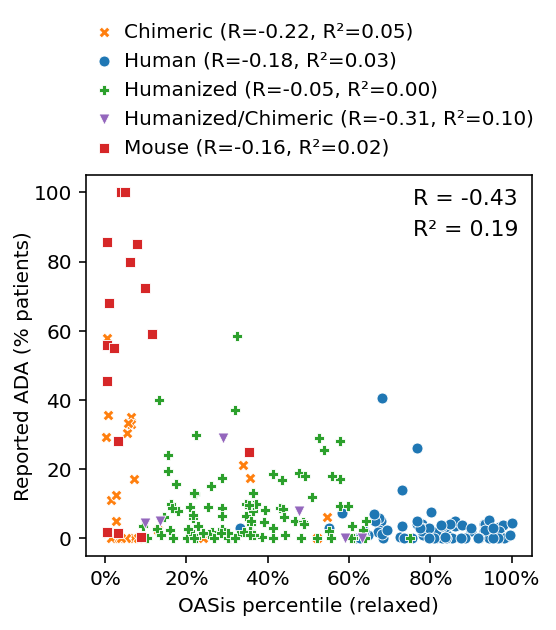

OASis percentile (medium)   R = -0.43     R² = 0.19  


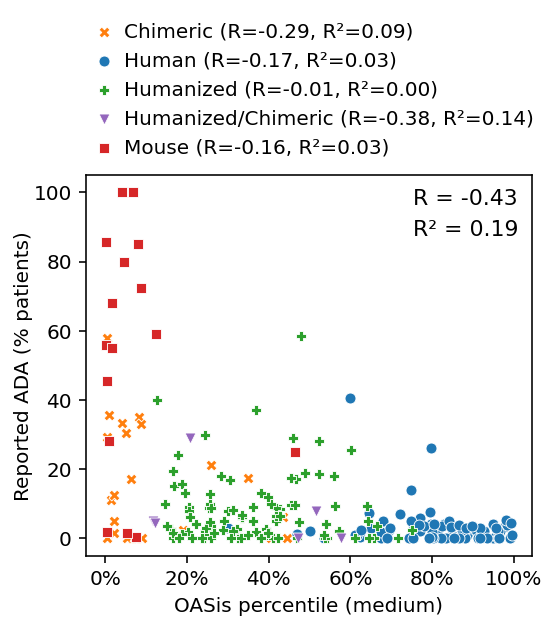

OASis percentile (strict)   R = -0.46     R² = 0.21  


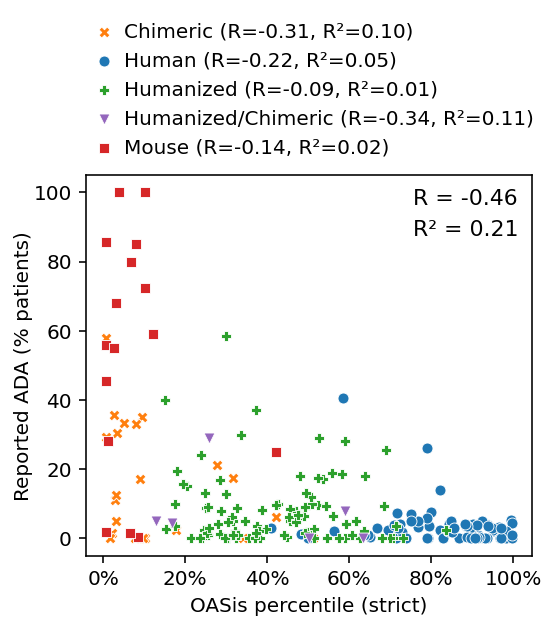

,R,R2
method,,
T20,-0.405406,0.164354
Z-score,-0.451263,0.203638
IgReconstruct,-0.447518,0.200272
AbLSTM,0.470962,0.221805
Germline content,-0.501034,0.251035
Hu-mAb,-0.584119,0.341195
MG Score,-0.456152,0.208075
"Non-human MHCII binders\n(predicted NetMHCIIpan 3.1, OASis loose)",0.447468,0.023616
"Non-human MHCII binders\n(predicted NetMHCIIpan 3.1, OASis relaxed)",0.457048,0.015443


In [37]:
plot_correlations(mabs['Immunogenicity'], SCORES, hue=mabs['Species'], colors=COLORS)

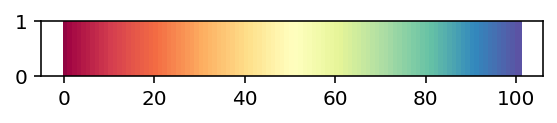

In [38]:
fig, ax = plt.subplots(figsize=(4.5, 0.5))
SPECTRAL = ['#920542', '#a20643', '#a90d45', '#ad1246', '#b41947', '#b81e48', '#be254a', '#c32a4b', '#c9314c', '#cd364d', '#d43d4f', '#d7414e', '#da464d', '#dd4a4c', '#e1504b', '#e45549', '#e75948', '#ea5e47', '#ed6246', '#f06744', '#f36b43', '#f57245', '#f57748', '#f67f4b', '#f7844e', '#f88c51', '#f99153', '#fa9857', '#fb9d59', '#fca55d', '#fdad60', '#fdb163', '#fdb768', '#fdbb6c', '#fdc171', '#fdc574', '#feca79', '#fece7c', '#fed481', '#fed884', '#fede89', '#fee18d', '#fee593', '#fee797', '#feeb9d', '#feefa3', '#fff1a8', '#fff5ae', '#fff7b2', '#fffbb8', '#fffdbc', '#fefebd', '#fcfeba', '#f9fcb5', '#f7fcb2', '#f4faad', '#f2faaa', '#eff9a6', '#ecf7a1', '#eaf79e', '#e7f59a', '#e4f498', '#ddf19a', '#d8ef9b', '#d1ed9c', '#cdeb9d', '#c6e89f', '#c1e6a0', '#bae3a1', '#b5e1a2', '#aedea3', '#aadca4', '#a2d9a4', '#99d6a4', '#94d4a4', '#8cd1a4', '#86cfa5', '#7ecca5', '#79c9a5', '#71c6a5', '#6bc4a5', '#64c0a6', '#60bba8', '#5ab4ab', '#56b0ad', '#50a9af', '#4ba4b1', '#459eb4', '#3f97b7', '#3b92b9', '#358bbc', '#3387bc', '#3880b9', '#3b7cb7', '#4175b4', '#4471b2', '#496aaf', '#4d65ad', '#525fa9', '#555aa7', '#5b53a4']
for i in range(0, 101):
    ax.axvspan(i, i+1, color=SPECTRAL[i])

In [39]:
def plot_rocs(y, scores, invert=False, baseline=True, figsize=(8, 8)):
    print('Classes:', y.value_counts().to_dict())
    fig, ax = plt.subplots(figsize=figsize)
    for i, (multiplier, score, ls, color, lw) in enumerate(scores):
        shared_index = y.index[~score.loc[y.index].isna()]
        if len(shared_index) != len(y.index):
            print()
            print(f'Note! Evaluating only {len(shared_index)}/{len(y.index)} samples for {score.name}')
            print()
        plot_roc_curve(
            y.loc[shared_index], 
            (-1 if invert else 1) * multiplier * score.loc[shared_index], 
            baseline=baseline and (i == len(scores)-1), 
            label=score.name, 
            lw=lw, 
            color=color, 
            ls=ls, 
            ax=ax
        );
        

# Immunogenicity classification

## Immunogenicity >= 10%

Classes: {False: 164, True: 53}
T20: 0.770 AUC
Z-score: 0.749 AUC
IgReconstruct: 0.784 AUC
AbLSTM: 0.769 AUC
Germline content: 0.805 AUC
Hu-mAb: 0.830 AUC
MG Score: 0.803 AUC
Non-human MHCII binders
(predicted NetMHCIIpan 3.1, OASis loose): 0.756 AUC
Non-human MHCII binders
(predicted NetMHCIIpan 3.1, OASis relaxed): 0.769 AUC
Non-human MHCII binders
(predicted NetMHCIIpan 3.1, OASis medium): 0.778 AUC
Non-human MHCII binders
(predicted NetMHCIIpan 3.1, OASis strict): 0.765 AUC
OASis identity (loose): 0.783 AUC
OASis identity (relaxed): 0.788 AUC
OASis identity (medium): 0.799 AUC
OASis identity (strict): 0.800 AUC
OASis percentile (loose): 0.783 AUC
OASis percentile (relaxed): 0.788 AUC
OASis percentile (medium): 0.799 AUC
OASis percentile (strict): 0.800 AUC


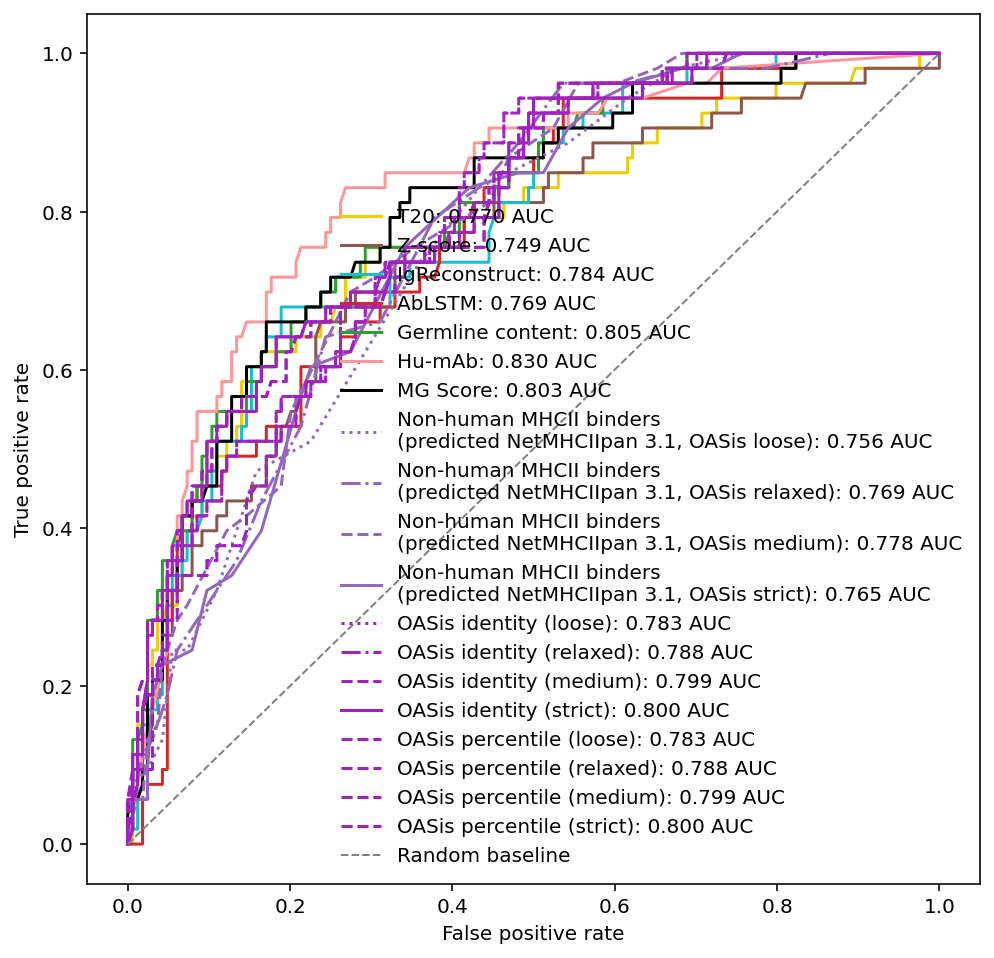

In [40]:
plot_rocs(mabs['Immunogenicity'] >= 10, SCORES, invert=True)

Classes: {False: 164, True: 53}
T20: 0.770 AUC
Z-score: 0.749 AUC
IgReconstruct: 0.784 AUC
AbLSTM: 0.769 AUC
Germline content: 0.805 AUC
Hu-mAb: 0.830 AUC
MG Score: 0.803 AUC
OASis identity: 0.799 AUC
OASis percentile: 0.799 AUC


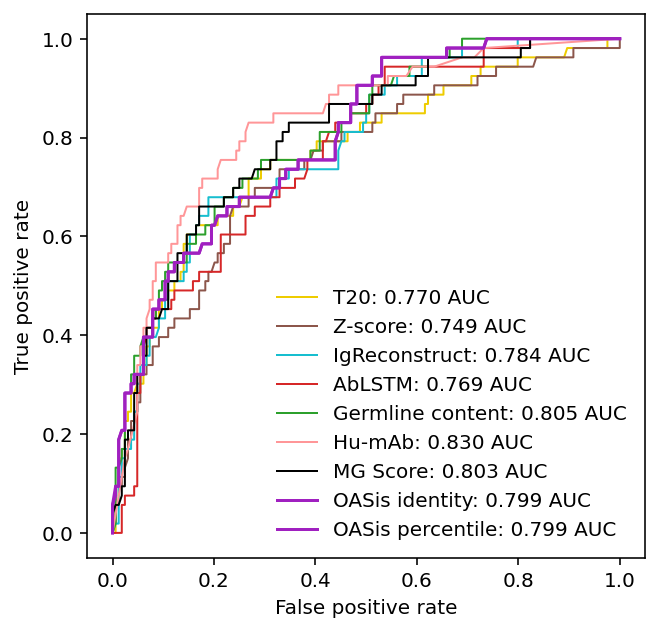

In [41]:
plot_rocs(mabs['Immunogenicity'] >= 10, SELECTED_SCORES, invert=True, baseline=False, figsize=(5, 5))

In [42]:
def get_performance(y, scores, invert=False):
    performance = []
    for multiplier, score, ls, color, lw in scores:
        shared_index = y.index[~score.loc[y.index].isna()]
        if len(shared_index) != len(y.index):
            print()
            print(f'Note! Evaluating only {len(shared_index)}/{len(y.index)} samples for {score.name}')
            print()
        score = (-1 if invert else 1) * multiplier * score.loc[shared_index]
        performance.append({
            'Method': score.name,
            'Max Accuracy': max(metrics.accuracy_score(y.loc[shared_index], score >= threshold) for threshold in score),
            'ROC AUC': metrics.roc_auc_score(y.loc[shared_index], score)
        })
    return pd.DataFrame(performance).set_index('Method')

In [43]:
immunogenic10_classification = get_performance(mabs['Immunogenicity'] >= 10, SCORES, invert=True)
immunogenic10_classification.apply(lambda col: col.apply('{:.1%}'.format))

,Max Accuracy,ROC AUC
Method,,
T20,79.7%,77.0%
Z-score,79.3%,74.9%
IgReconstruct,79.7%,78.4%
AbLSTM,80.6%,76.9%
Germline content,81.1%,80.5%
Hu-mAb,82.5%,83.0%
MG Score,80.6%,80.3%
"Non-human MHCII binders\n(predicted NetMHCIIpan 3.1, OASis loose)",77.4%,75.6%
"Non-human MHCII binders\n(predicted NetMHCIIpan 3.1, OASis relaxed)",77.0%,76.9%


In [44]:
oasis_missed_immunogenic10 = pd.DataFrame(oasis_medium).join(mabs[mabs['Immunogenicity'] >= 10], how='inner').sort_values(by=oasis_medium.name, ascending=False)
oasis_missed_immunogenic10.head(10)

,OASis identity (medium),Immunogenicity,Species,Reference
Name,,,,
Tarextumab,0.874396,26.0,Human,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6647865/
Adalimumab,0.839623,14.0,Human,https://www.nature.com/articles/s41598-018-32986-y#ref-CR1
Bococizumab,0.746411,25.5,Humanized,https://www.ncbi.nlm.nih.gov/pubmed/31529318
Utomilumab,0.745192,40.7,Human,https://jitc.biomedcentral.com/articles/10.1186/s40425-019-0815-6\nhttps://clincancerres.aacrjournals.org/content/24/8/1816.long
Romosozumab,0.728972,18.1,Humanized,https://www.accessdata.fda.gov/drugsatfda_docs/label/2019/761062s000lbl.pdf
Nirsevimab,0.709677,28.0,Humanized,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6133204/
Elotuzumab,0.709524,18.5,Humanized,https://www.nature.com/articles/s41598-018-32986-y#ref-CR1
Daclizumab,0.694175,19.0,Humanized,https://www.nature.com/articles/s41598-018-32986-y#ref-CR1
Disitamab,0.691176,58.6,Humanized,https://www.sciencedirect.com/science/article/pii/S0378427419304217?via%3Dihub


In [45]:
oasis_false_positive = pd.DataFrame(oasis_medium).join(mabs[mabs['Immunogenicity'] == 0], how='inner').sort_values(by=oasis_medium.name, ascending=True)
oasis_false_positive.head(10)

,OASis identity (medium),Immunogenicity,Species,Reference
Name,,,,
Ublituximab,0.201923,0.0,Chimeric,https://www.tgtherapeutics.com/EHA2013PosterP111.pdf
Futuximab,0.345794,0.0,Chimeric,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6172077/
Modotuximab,0.367442,0.0,Chimeric,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6172077/
Loncastuximab,0.370192,0.0,Chimeric,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7013258/
Zolbetuximab,0.404651,0.0,Chimeric,https://www.ejcancer.com/article/S0959-8049(18)30847-5/fulltext#sec2.3.3
Gemtuzumab,0.559242,0.0,Humanized,https://www.nature.com/articles/s41598-018-32986-y#ref-CR1
Cinpanemab,0.575610,0.0,Humanized,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6771554/
Labetuzumab,0.612440,0.0,Humanized,https://ascopubs.org/doi/full/10.1200/JCO.2017.73.9011?url_ver=Z39.88-2003&rfr_id=ori:rid:crossref.org&rfr_dat=cr_pub%3dpubmed
Pexelizumab,0.614634,0.0,Humanized,https://www.nature.com/articles/s41598-018-32986-y#ref-CR1


In [46]:
humab_missed_immunogenic10 = pd.DataFrame(humab).join(mabs[mabs['Immunogenicity'] >= 10], how='inner').sort_values(by=humab.name, ascending=False)
humab_missed_immunogenic10.head(10)

,Hu-mAb,Immunogenicity,Species,Reference
Name,,,,
Nirsevimab,1.0000,28.0,Humanized,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6133204/
Adalimumab,0.9995,14.0,Human,https://www.nature.com/articles/s41598-018-32986-y#ref-CR1
Utomilumab,0.9975,40.7,Human,https://jitc.biomedcentral.com/articles/10.1186/s40425-019-0815-6\nhttps://clincancerres.aacrjournals.org/content/24/8/1816.long
Tarextumab,0.9900,26.0,Human,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6647865/
Atezolizumab,0.9580,28.9,Humanized,https://www.nature.com/articles/s41598-018-32986-y#ref-CR1
Bococizumab,0.8855,25.5,Humanized,https://www.ncbi.nlm.nih.gov/pubmed/31529318
Bimekizumab,0.8775,12.8,Humanized,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5401985/
Talacotuzumab,0.8750,17.5,Humanized,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5061540/
Lifastuzumab,0.8350,18.0,Humanized,https://clincancerres.aacrjournals.org/content/early/2019/09/20/1078-0432.CCR-18-3965.full-text.pdf


In [47]:
humab_false_positive = pd.DataFrame(humab).join(mabs[mabs['Immunogenicity'] == 0], how='inner').sort_values(by=humab.name, ascending=True)
humab_false_positive.head(10)

,Hu-mAb,Immunogenicity,Species,Reference
Name,,,,
Zolbetuximab,0.0000,0.0,Chimeric,https://www.ejcancer.com/article/S0959-8049(18)30847-5/fulltext#sec2.3.3
Modotuximab,0.0000,0.0,Chimeric,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6172077/
Ublituximab,0.0025,0.0,Chimeric,https://www.tgtherapeutics.com/EHA2013PosterP111.pdf
Futuximab,0.0375,0.0,Chimeric,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6172077/
Loncastuximab,0.2125,0.0,Chimeric,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7013258/
Ficlatuzumab,0.6200,0.0,Humanized,https://www.ncbi.nlm.nih.gov/pubmed/24901237\nhttps://accp1.onlinelibrary.wiley.com/doi/full/10.1002/cpdd.427
Galiximab,0.6475,0.0,Chimeric,https://www.annalsofoncology.org/article/S0923-7534(19)41214-3/fulltext
Birtamimab,0.6825,0.0,Humanized/Chimeric,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5470113/
Labetuzumab,0.7345,0.0,Humanized,https://ascopubs.org/doi/full/10.1200/JCO.2017.73.9011?url_ver=Z39.88-2003&rfr_id=ori:rid:crossref.org&rfr_dat=cr_pub%3dpubmed


# Table export

In [48]:
vhs = {r.id: str(r.seq) for r in iterate_fasta(PREFIX+'.fa') if r.description.endswith(' VH')}
vls = {r.id: str(r.seq) for r in iterate_fasta(PREFIX+'.fa') if r.description.endswith(' VL')}

In [49]:
table = mabs
table['VH'] = mabs.index.map(vhs.get)
table['VL'] = mabs.index.map(vls.get)
for multiplier, score, ls, color, lw in SCORES:
    table = table.join(score, how='outer')
table.index.name = 'Antibody'
table.head()

,Immunogenicity,Species,Reference,VH,VL,T20,Z-score,IgReconstruct,AbLSTM,Germline content,...,"Non-human MHCII binders\n(predicted NetMHCIIpan 3.1, OASis medium)","Non-human MHCII binders\n(predicted NetMHCIIpan 3.1, OASis strict)",OASis identity (loose),OASis identity (relaxed),OASis identity (medium),OASis identity (strict),OASis percentile (loose),OASis percentile (relaxed),OASis percentile (medium),OASis percentile (strict)
Antibody,,,,,,,,,,,,,,,,,,,,,
3F8,100.0,Mouse,https://www.nature.com/articles/s41598-018-32986-y#ref-CR1,QVQLKESGPGLVAPSQSLSITCTVSGFSVTNYGVHWVRQPPGKGLEWLGVIWAGGITNYNSAFMSRLSISKDNSKSQVFLKMNSLQIDDTAMYYCASRGGHYGYALDYWGQGTSVTVSS,SIVMTQTPKFLLVSAGDRVTITCKASQSVSNDVTWYQQKAGQSPKLLIYSASNRYSGVPDRFTGSGYGTAFTFTISTVQAEDLAVYFCQQDYSSFGGGTKLEIK,74.179020,-1.3485,-3.815430,1.272985,0.634252,...,31,32,0.681159,0.497585,0.289855,0.202899,0.050262,0.038151,0.040729,0.037748
Abagovomab,68.1,Mouse,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3221001/,QVKLQESGAELARPGASVKLSCKASGYTFTNYWMQWVKQRPGQGLDWIGAIYPGDGNTRYTHKFKGKATLTADKSSSTAYMQLSSLASEDSGVYYCARGEGNYAWFAYWGQGTTVTVSS,DIELTQSPASLSASVGETVTITCQASENIYSYLAWHQQKQGKSPQLLVYNAKTLAGGVSSRFSGSGSGTHFSLKIKSLQPEDFGIYYCQHHYGILPTFGGGTKLEIK,67.553070,-1.6235,-2.992780,1.304958,0.669324,...,24,24,0.633333,0.433333,0.233333,0.190476,0.026596,0.008274,0.015366,0.030480
Abciximab,35.5,Chimeric,https://www.nature.com/articles/s41598-018-32986-y#ref-CR1,EVQLQQSGAELVKPGASVKLSCTASGFNIKDTYVHWVKQRPEQGLEWIGRIDPANGYTKYDPKFQGKATITADTSSNTAYLQLSSLTSEDTAVYYCVRPLYDYYAMDYWGQGTSVTVSS,DILMTQSPSSMSVSLGDTVSITCHASQGISSNIGWLQQKPGKSFMGLIYYGTNLVDGVPSRFSGSGSGADYSLTISSLDSEDFADYYCVQYAQLPYTFGGGTKLEIK,66.049270,-1.5380,-3.868209,1.266076,0.656248,...,24,25,0.595238,0.428571,0.209524,0.180952,0.005404,0.006586,0.008612,0.025329
Abrilumab,0.4,Human,https://www.gastrojournal.org/article/S0016-5085(18)35283-1/fulltext?referrer=https%3A%2F%2Fwww.ncbi.nlm.nih.gov%2F,QVQLVQSGAEVKKPGASVKVSCKVSGYTLSDLSIHWVRQAPGKGLEWMGGFDPQDGETIYAQKFQGRVTMTEDTSTDTAYMELSSLKSEDTAVYYCATGSSSSWFDPWGQGTLVTVSS,DIQMTQSPSSVSASVGDRVTITCRASQGISSWLAWYQQKPGKAPKLLIYGASNLESGVPSRFSGSGSGTDFTLTISSLQPEDFANYYCQQANSFPWTFGQGTKVEIK,90.070785,0.1330,0.830371,0.272131,0.929590,...,3,3,0.990431,0.985646,0.875598,0.856459,0.969459,0.985731,0.800918,0.886601
Actoxumab,0.0,Human,MK-3415 no ADA present\nhttps://www.tga.gov.au/sites/default/files/auspar-bezlotoxumab-180924-cer.pdf,QVQLVESGGGVVQPGRSLRLSCAASGFSFSNYGMHWVRQAPGKGLEWVALIWYDGSNEDYTDSVKGRFTISRDNSKNTLYLQMNSLRAEDTAVYYCARWGMVRGVIDVFDIWGQGTVVTVSS,DIQMTQSPSSVSASVGDRVTITCRASQGISSWLAWYQHKPGKAPKLLIYAASSLQSGVPSRFSGSGSGTDFTLTISSLQPEDFATYYCQQANSFPWTFGQGTKVEIK,91.921520,1.0095,0.068102,0.444257,0.920408,...,4,5,0.976526,0.924883,0.892019,0.868545,0.894957,0.797539,0.854319,0.905995


In [50]:
table.to_csv(PREFIX+'_all_scores.tsv', sep='\t')